<a href="https://colab.research.google.com/github/urmzd/school/blob/main/year-four/CSCI4155/assignments/a1/Assignment1-Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1


In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this assignment you will be implementing some components of neural networks in numpy from scratch (all your code should be vectorized; and you shouldn’t use any library besides numpy and matplotlib). Base meta classes for the various activations, layers and optimizers are provided; all of your implementations must be classes that inherit from the appropriate base meta class. **When implementing backwards passes, please include in Markdown an analytical derivation of the backwards pass.**


# Step 1: Fully-connected neural networks


## General comments

In this step you will implement all the components you need to construct and train a fully-connected neural network: the forward and backwards passes for various activations and types of layers, a loss (baked into the SoftMax class), a class to hold the stacked layers together and a couple of optimizers.

The forward pass is relatively straightforward: each layer outputs an array that the following layer takes as its input. The backwards pass, on the other hand, is a bit more complicated and to be able to complete it, you need to both have the incoming gradient and the original input to each layer, represented by the variable "original_input" in our code. The gradient returned by the backward() call of any given layer is then used as input for the backward() call of the layer immediately preceding it.


In [94]:
import matplotlib.pyplot as plt
import numpy as np


# 1.

Implement the forwards and backwards passes for the following activations: a) Sigmoid, $\sigma(x) = \frac{1}{1+e^{-x}}$; b) Tanh, tthat returns the tangent hyperbolic function of its input, $y = tanh(x)$. The ReLU class is done for you as an example.

**Note that defining the ** call ** function allows you to avoid calling the forward function directly, i.e. instead of calling ReLU.forward(x), you should call ReLU(x) instead (for example).**


#### ReLu

$$
  f(x) := \max(0, x)
$$

$$
  \frac{d}{dx} := \begin{cases}
    1, x \geq 0\\
    0, x < 0
  \end{cases}
$$

#### Sigmoid

$$
  f(x) := \frac{1}{1 + e^{-x}}
$$

$$ \frac{d}{dx} := f(x) \cdot (1 - f(x)) $$

#### Tanh

$$ f(x) := \tanh{x} $$
$$ \frac{d}{dx} := 1 - \tanh^2{x}$$


In [95]:
import abc

# Abstract base class for all activation classes
class Activations(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self, x):
        return

    @abc.abstractmethod
    def backward(self, grad, original_input):
        return


class ReLU(Activations):
    def forward(self, x):
        # return result
        return np.maximum(0, x)

    def backward(self, grad, original_input):
        # this assumes that the original input to this layer has been saved somewhere else
        x = original_input
        return grad * (x > 0)

    def __call__(self, x, mode=None):
        return self.forward(x)


class Sigmoid(Activations):
    def _activate(self, x: np.ndarray):
        divisor = 1 + np.power(np.e, -x)
        return np.reciprocal(divisor)

    def forward(self, x):
        return self._activate(x)

    def backward(self, grad, original_input):
        sigma = self._activate(original_input)
        activation = sigma * (1 - sigma)
        cost_wrt_activation = activation * grad

        return cost_wrt_activation

    def __call__(self, x, mode=None):
        return self.forward(x)


class Tanh(Activations):
    def forward(self, x):
        return np.tanh(x)

    def backward(self, grad, original_input):
        activation = 1 - np.square(np.tanh(original_input))
        cost_wrt_activation = activation * grad

        return cost_wrt_activation

    def __call__(self, x, mode=None):
        return self.forward(x)


# 2.

Implement an activation (“SoftmaxCrossLoss”) that has two modes of operation: a) if a target, $y_{true}$, is provided then it operates in the same manner as the Pytorch CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (basically the usual softmax activation plus a cross-entropy loss); b) if no target $y_{true}$ is provided, then the forward pass just returns the softmax of the input (no backwards pass needs to be implemented for this mode): for a vector $\mathbf{x}=(x_1,x_2, \cdots, x_n)$, Softmax $(\mathbf{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$ (when using batches this operation should be done for each vector in the batch).

While implementing softmax shift your input by using shifted_x = x - np.max(x, axis=1, keepdims=True). This does not affect the result of the softmax operation and improves numerical stability.

Note that "mode" is included in this class's function calls just to keep a unified interface for use in the fully-connected neural network.


# Softmax

$$
  S(x) := \frac{e^{x_i}}{\sum_{j}{e^{x_j}}}\\
  \frac{\partial{S}}{\partial{x_i}} := \begin{cases}
    S_i \times (1 - S_j), i = j \\
    - S_i \times S_j, i \neq j
  \end{cases}
$$

# Cross Entropy

$$
E := -\sum_i{y_i}\cdot\log{S_i}\\
\begin{align}
\frac{\partial{E}}{\partial{x_j}} &:= -\sum_i{\frac{\partial{y_i \cdot \log{S_i}}}{\partial{x_j}}}\\
&:= -\sum_i{y_i \cdot \frac{\partial{\log{S_i}}}{\partial{x_j}}}\\
&:= -\sum_i{y_i \cdot \frac{\partial{\log{S_i}}}{\partial{S_i}}} \cdot \frac{\partial{S_i}}{\partial{x_j}}\\
&:= -\sum_i{y_i \cdot \frac{1}{S_i} \times \frac{\partial{S_i}}{\partial{x_j}}}\\
&:= -\sum_{i \neq j}{[y_i \cdot \frac{1}{S_i} \cdot -(S_i \cdot S_j)]} - [y_i \cdot \frac{1}{S_i} \cdot (S_i \cdot (1 - S_j))]\\
&:= -\sum_{i \neq j}{[y_i \cdot  S_j]} - [y_i \cdot (1 - S_j)] \\
&:= S_j \cdot \sum_{i \neq j}{y_i} - [y_i \cdot (1 - S_j)] \\
&:= S_j \cdot \sum_{i}{y_i} - y_i
\end{align}
$$


In [96]:
class SoftMaxCrossLoss(Activations):
    def __init__(self):
        self.probs = None
        self.y = None

    def _stable_soft_max(self, x, axis=1):
        shifted_x = x - np.max(x, axis=axis, keepdims=True)
        exp = np.exp(shifted_x)
        z = exp / np.sum(exp, axis=axis, keepdims=True)

        return z

    def forward(self, x, y=None):
        z = self._stable_soft_max(x)

        if y is None:
            return z

        loss = -np.log(z, where=(z != 0)) * y

        self.y = y
        self.probs = z

        return np.average(loss)

    def backward(self, grad, original_input):
        return self.probs - self.y

    def __call__(self, x, y=None, mode=None):
        return self.forward(x, y)


# 3.

Implement three layers (with both forward and backwards passes): a) an AffineLayer (with input dimension input_dim and hidden units hidden_dim), whose forward pass returns $Y=Xw^T + b$, where w and b are the weights and bias respectively; b) an Inverted Dropout (https://machinelearning.wtf/terms/inverted-dropout/) layer that keeps weights with probability p; c) **Only for 6505 students**: a BatchNorm layer.

Note that the gradients of the parameters of each layer should be kept inside their respective layers. Dropout and Batchnorm behave different based on whether we are in "train" or "test" mode.


# Affine Layer

$$
  Y = Xw^{T} + b\\
  \frac{\partial{Y}}{\partial{X}} = w^{T}\\
  \frac{\partial{Y}}{\partial{b}} = 1 \\
  \frac{\partial{Y}}{\partial{w}} = X
$$


In [97]:
class Layers(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self, x):
        return

    @abc.abstractmethod
    def backward(self, grad, original_input):
        return


class AffineLayer(Layers):
    def __init__(self, input_dim, hidden_units):
        ran = np.sqrt(1 / input_dim)

        # Initializing the weights and bias, in that order
        self.parameters = [
            np.random.uniform(-ran, ran, (hidden_units, input_dim)),
            np.random.uniform(-ran, ran, hidden_units),
        ]

        self.grads = [
            np.zeros_like(self.parameters[0]),
            np.zeros_like(self.parameters[1]),
        ]

    def forward(self, x):
        w, b = self.parameters
        return x @ w.T + b

    def backward(self, grad, original_input):
        w, _ = self.parameters

        dx = grad @ w
        dw = grad.T @ original_input
        db = np.sum(grad, axis=0)

        self.grads[0] = dw
        self.grads[1] = db

        return dx

    def __call__(self, x, mode=None):
        return self.forward(x)


class Dropout(Layers):
    def __init__(self, p):
        self.p = p
        self.mask = None

    def forward(self, x, mode):
        if mode == "train":
            self.mask = (np.random.rand(*x.shape) < self.p) / self.p
            return self.mask * x
        else:
            return self.mask * x

    def backward(self, grad, original_input):
        return grad * self.mask

    def __call__(self, x, mode="test"):
        return self.forward(x, mode)


# 4.

Implement a fully connected neural network that takes as input some user-defined layers and has both forward and backward passes (you should use the forward and backward passes from the previously defined layers).


In [98]:
class FCNN:
    def __init__(self, layers):
        self.layers = layers
        self.original_inputs = []

    def forward(self, x, y=None, mode="test"):
        self.original_inputs = [x.copy()]

        for layer in self.layers:
            prev_output = self.original_inputs[-1]
            new_output = (
                layer(x=prev_output, mode=mode, y=y)
                if isinstance(layer, SoftMaxCrossLoss)
                else layer(x=prev_output, mode=mode)
            )

            self.original_inputs.append(new_output)

        return self.original_inputs[-1]

    def backward(self):
        # Pop loss value from the cache
        loss = self.original_inputs.pop()
        grad = None

        L = len(self.layers)

        for l in range(L - 1, 0, -1):
            layer = self.layers[l]
            inp = self.original_inputs.pop()
            grad = layer.backward(grad=grad, original_input=inp)

    def __call__(self, x, y=None, mode="test"):
        return self.forward(x, y, mode)


# 5.

Implement the following optimizers: a) stochastic gradient descent with momentum; b) **Only for 6505 students**: the Adam optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html). These optimizers should take as input a layer and update their parameters according to the gradients stored in the layers.

Note that Adam requires you to keep a track of the running means of gradients. A python dictionary to organize this might prove useful.


In [99]:
class Optimizer(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def step(self, layer):
        return


class SGD(Optimizer):
    def __init__(self, momentum, alpha=0.001):
        self.momentum = momentum
        self.prev_m_b = None
        self.prev_m_w = None
        self.alpha = alpha

    def step(self, layer):
        _, b = layer.parameters
        w_grad, b_grad = layer.grads

        batch_no = np.random.randint(b.shape[0])
        
        w_grad_random_index = w_grad[batch_no]
        b_grad_random_index = b_grad[batch_no]

        if self.prev_m_w is None and self.prev_m_b is None:
          self.prev_m_w = self.alpha * w_grad_random_index
          self.prev_m_b = self.alpha * b_grad_random_index
        else:
            self.prev_m_w = self.momentum * self.prev_m_w + self.alpha * w_grad_random_index
            self.prev_m_b = self.momentum * self.prev_m_b + self.alpha * b_grad_random_index

        layer.parameters[0][batch_no] -= self.prev_m_w
        layer.parameters[1][batch_no] -= self.prev_m_b

    def __call__(self, layer):
        self.step(layer)


# 6.

Test out several fully connected architectures on the reduced MNIST dataset provided. Feed the dataset to your network in batches and experiment with the batch size.

a) Experiment with the batch size. Does the batch size impact performance?

b) Do you do better with two or three layers? Experiment with the hidden units in each layers.

c) Does adding more layers continually improve your results?

d) Does Dropout help?

e) What can you say about the difficulty of training as you add layers?

f) **Only for 6505 students**: Does Batchnorm improve results?

g) **Only for 6505 students**: Try using the Adam optimizer. Do you converge more quickly? Do you get better results?

**Download train.npz and test.npz from the Assignment 1 Files folder on teams. The data contains several thousand images represented by arrays of shape (28,28); before feeding it to your network you should flatten them so that each image has shape (784,).**


In [100]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder


def load_data():
    # Update prefix to be nothing on local machine.
    prefix="/content/drive/MyDrive/"
    train_data = np.load(prefix + "train.npz")["arr_0"]
    train_targets = np.load(prefix +"train.npz")["arr_1"]

    test_data = np.load(prefix + "test.npz")["arr_0"]
    test_targets = np.load(prefix + "test.npz")["arr_1"]

    y_encoder = None

    def and_reshape(train_mode=True):
        x, y = (train_data, train_targets) if train_mode else (test_data, test_targets)

        x_reshaped = x.reshape(-1, x.shape[1] ** 2)
        y_reshaped = y.reshape(-1, 1)

        nonlocal y_encoder
        if not y_encoder:
            y_encoder = OneHotEncoder()
            y_encoder.fit(y_reshaped)
            y_reshaped = y_encoder.transform(y_reshaped).toarray()

        return x_reshaped, y_reshaped, y_encoder

    return and_reshape


In [101]:
import time

np.seterr("ignore")


def get_training_and_testing_accuracies_and_plot(layers, batch_size=32, n_epochs=4, mu=0.99):

    layers.insert(0, AffineLayer(784, batch_size))
    layers.append(SoftMaxCrossLoss())

    print(list(map(lambda layer: type(layer), layers)))

    optimizers = []
    for layer in layers:
      if isinstance(layer, AffineLayer):
        optimizers.append((SGD(mu), layer))

    print("-----------------------------------------------------")
    print()
    print()

    data_loader = load_data()
    x_train, y_train, encoder = data_loader(train_mode=True)

    neural_net = FCNN(layers)

    train_start = 0
    train_end = train_start + batch_size

    
    start_time = time.time()

    total_error = []
    for epoch in range(n_epochs):

      losses = []
      while train_start < y_train.shape[0]:
          # Forward Prop
          x_batch = x_train[train_start:train_end]
          y_batch = y_train[train_start:train_end]
          loss = neural_net.forward(x_batch, y_batch, mode="train")
          losses.append(loss)

          # Back Prop
          neural_net.backward()

          # Parameter Update
          for optimizer in optimizers:
              optimizer[0](optimizer[1])

          # Next Batch
          train_start += batch_size
          train_end += batch_size


      # RESTART
      train_start = 0
      train_end = batch_size
      total_error.append(np.average(np.array(losses)))

    end_time = time.time()
    print(f"TRAINING TIME FOR {n_epochs} EPOCHS: {end_time - start_time}")
    print(f"AVERAGE TRAINING LOSS: {np.average(np.array(total_error))}")

    _, ax = plt.subplots()

    ax.set_title(
        f"Average Error Per Epoch, Batch Size = {batch_size}"
    )
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Average Error")
    ax.plot(total_error)

    x_test, y_test, _ = data_loader(train_mode=False)
    testing_accuracies = []

    test_start = 0
    test_end = batch_size

    start_time = time.time()

    while test_start < y_test.shape[0]:
        x_batch = x_test[test_start:test_end]
        y_batch = y_test[test_start:test_end]
        probs = neural_net.forward(x_batch)

        y_pred = np.argmax(probs, axis=1).reshape(-1, 1)
        accuracy = accuracy_score(y_batch, y_pred)
        testing_accuracies.append(accuracy)

        test_start += batch_size
        test_end += batch_size

    end_time = time.time()

    print(f"TESTING TIME: {end_time - start_time}")
    print(
        f"AVERAGE TESTING ACCURACY: {np.array(testing_accuracies).mean()}"
    )


[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.SoftMaxCrossLoss'>]
-----------------------------------------------------


TRAINING TIME FOR 4 EPOCHS: 6.218450546264648
AVERAGE TRAINING LOSS: 0.19213776142459038
TESTING TIME: 0.28327035903930664
AVERAGE TESTING ACCURACY: 0.4304
[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.SoftMaxCrossLoss'>]
-----------------------------------------------------


TRAINING TIME FOR 4 EPOCHS: 4.074681282043457
AVERAGE TRAINING LOSS: 0.1777465491333667
TESTING TIME: 0.17888522148132324
AVERAGE TESTING ACCURACY: 0.5225
[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.SoftMaxCrossLoss'>]
-----------------------------------------------------


TRAINING TIME FOR 4 EPOCHS: 5.04716014862060

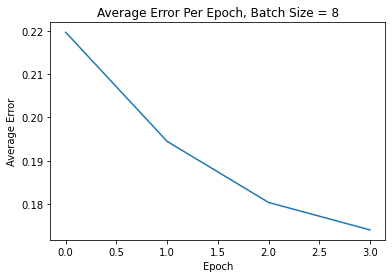

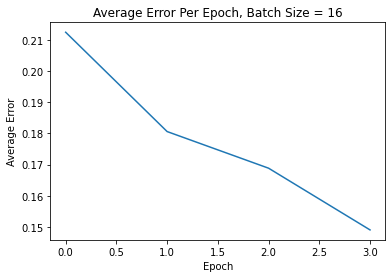

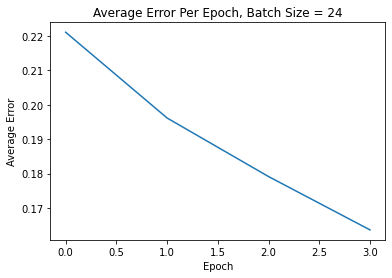

In [102]:
batch_sizes = [8 * i for i in range(1, 4)]

for batch_size in batch_sizes:
  layers=[
        AffineLayer(batch_size, 128), 
        ReLU(), 
        AffineLayer(128, 10), 
        ]
  get_training_and_testing_accuracies_and_plot(batch_size=batch_size, layers=layers)

# 6.a) Effect of Varying Batch Sizes

As batch size increases, operations are more computionally expensive, resulting in longer training times. However, the increase in batch size (to a reasonable extent) allows for better fitting as demonstrated above.


----------------------------------
2 LAYERS
[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.SoftMaxCrossLoss'>]
-----------------------------------------------------


TRAINING TIME FOR 4 EPOCHS: 4.249321699142456
AVERAGE TRAINING LOSS: 0.20728661007001117
TESTING TIME: 0.15916657447814941
AVERAGE TESTING ACCURACY: 0.33057108626198084
[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.SoftMaxCrossLoss'>]
-----------------------------------------------------


TRAINING TIME FOR 4 EPOCHS: 4.989656925201416
AVERAGE TRAINING LOSS: 0.20716970594683032
TESTING TIME: 0.17459487915039062
AVERAGE TESTING ACCURACY: 0.3667132587859425
[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__

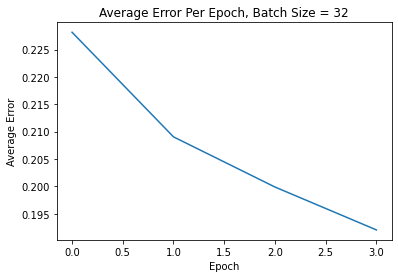

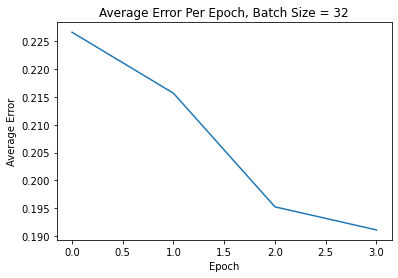

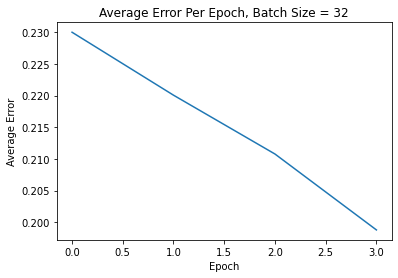

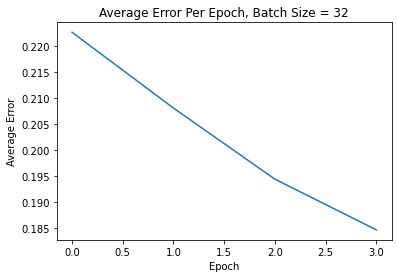

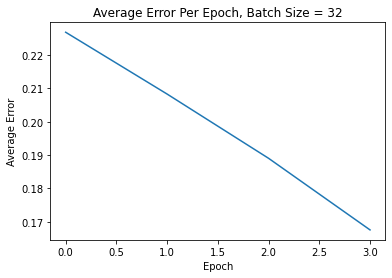

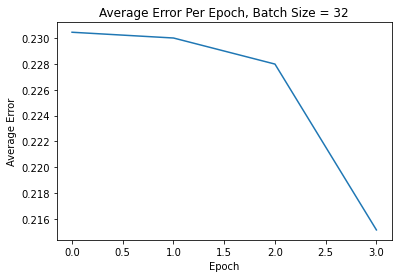

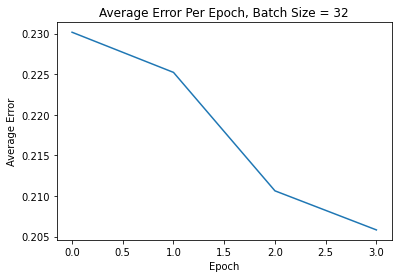

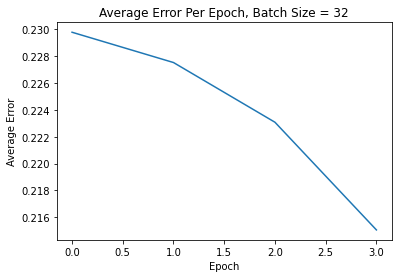

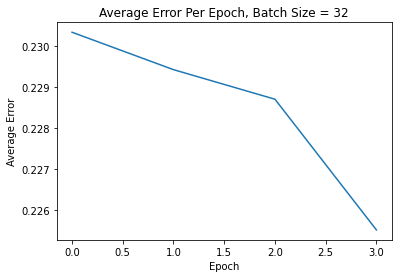

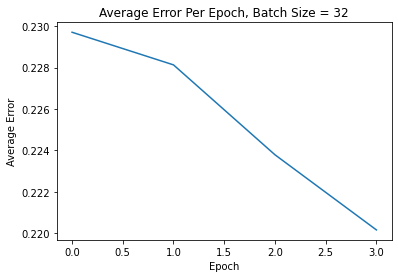

In [103]:
hidden_units_2_layer = [(32, 64), (64, 128), (128, 256), (256, 512), (512, 1024)]
hidden_units_3_layer = [(32, 64, 64), (64, 128, 128), (128, 256, 256), (256, 512, 256), (512, 1024, 512)]

print("----------------------------------")
print("2 LAYERS")
for hidden_unit in hidden_units_2_layer:
  batch_size = 32
  layers = [AffineLayer(batch_size, hidden_unit[0]), ReLU(), AffineLayer(hidden_unit[0], hidden_unit[1]), ReLU(), AffineLayer(hidden_unit[1], 10)]
  get_training_and_testing_accuracies_and_plot(batch_size=batch_size, layers=layers)

print("----------------------------------")
print("3 LAYERS")
for hidden_unit in hidden_units_3_layer:
  batch_size = 32
  layers = [AffineLayer(batch_size, hidden_unit[0]), ReLU(), AffineLayer(hidden_unit[0], hidden_unit[1]), ReLU(), AffineLayer(hidden_unit[1], hidden_unit[2]), ReLU(), AffineLayer(hidden_unit[2], 10)]
  get_training_and_testing_accuracies_and_plot(batch_size=batch_size, layers=layers)



# 6.b) Two or Three Layers

In this specific case, the two layers model out performed the three layer model. There are a few potential reasons for this occurance, including the use of a relatively small batch size, the small dataset, or the random number of nodes assigned per layer.

In [104]:
batch_size=500
def get_layers(new_dimensions, batch_size=batch_size, include_drop_outs:float=0.):
  layers = [AffineLayer(batch_size, np.random.randint(batch_size)), ReLU()]

  index = -3 if include_drop_outs else -2
  if include_drop_outs:
    layers += [Dropout(include_drop_outs)]

  for new_dimension in new_dimensions:
    prev_layer = layers[index]
    prev_dimension = prev_layer.parameters[1].shape[0]
    current_layer_set = [
        AffineLayer(prev_dimension, new_dimension),
        ReLU()
    ]

    if include_drop_outs:
      current_layer_set += [Dropout(include_drop_outs)]

    layers += current_layer_set

  layers += [AffineLayer(layers[index].parameters[1].shape[0], 10)]
  return layers

[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.SoftMaxCrossLoss'>]
-----------------------------------------------------


TRAINING TIME FOR 4 EPOCHS: 9.708677768707275
AVERAGE TRAINING LOSS: 0.22719070134780434
TESTING TIME: 0.23060035705566406
AVERAGE TESTING ACCURACY: 0.21539999999999998
[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.AffineLayer'>, <class '__main__.SoftMaxCrossLoss'>]
-----------------------------------------------------


TRAINING TIME FOR 4 EPOCHS: 12.696049451828003
AVERAGE TRAINING LOSS: 0.2310745013846754
TESTING TIME: 0.28553867340

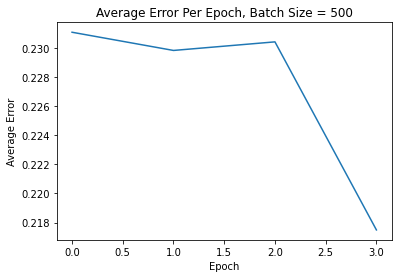

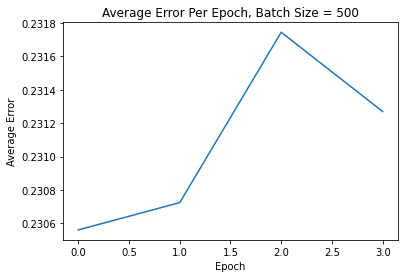

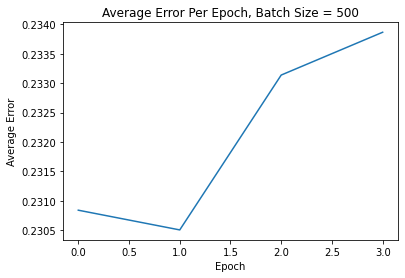

In [105]:
dimensions_to_test = [(128, 128), (128, 128, 128), (128, 128, 128, 128)]

for dimensions in dimensions_to_test:
  layers_to_test = get_layers(new_dimensions=dimensions)
  get_training_and_testing_accuracies_and_plot(layers=layers_to_test, batch_size=batch_size)

# 6.c) Number of Layers

While limited, the data above suggests that an increase in layers without consideration for the layers dimensions can cause losses to overflow/underflow.
As values are increasing/decreasing quite significantly through each step,
its possible that the input to the softmax layer results in numerical instablity, and hence the `NaNs` seen.

[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.Dropout'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.Dropout'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.Dropout'>, <class '__main__.AffineLayer'>, <class '__main__.SoftMaxCrossLoss'>]
-----------------------------------------------------


TRAINING TIME FOR 4 EPOCHS: 14.705385684967041
AVERAGE TRAINING LOSS: 0.23166301938101927
TESTING TIME: 0.31430959701538086
AVERAGE TESTING ACCURACY: 0.1015
[<class '__main__.AffineLayer'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.Dropout'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.Dropout'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.Dropout'>, <class '__main__.AffineLayer'>, <class '__main__.ReLU'>, <class '__main__.Dropout'>, <class '__main__.AffineLayer'>, <class '__main__.SoftMaxC

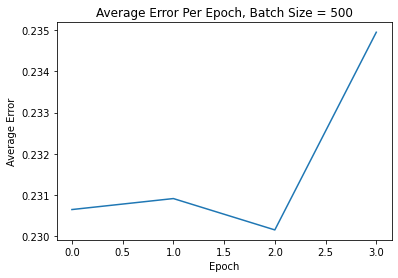

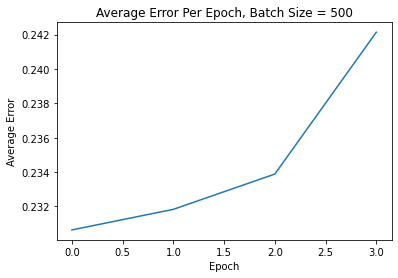

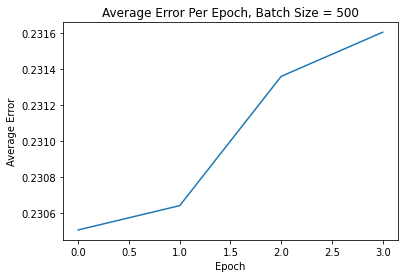

In [106]:
dimensions_to_test = [(128, 128), (128, 128, 128), (128, 128, 128, 128)]


for dimensions in dimensions_to_test:
  layers_to_test = get_layers(new_dimensions=dimensions, include_drop_outs=0.5)
  get_training_and_testing_accuracies_and_plot(layers=layers_to_test, batch_size=batch_size)

# 6.d) Dropout

Dropout does not help.

6.e) Performance Impact 

As the number of layers increase, training takes longer.